In [1]:
# Подключение пакетов
import os, sys, time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms

print('Numpy version:', np.version.version)

# Устанавливаем рабочую директорию в корень проекта
while not os.getcwd().endswith("seminar_4"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.config import oxford_iiit_cats_edges

data_config = oxford_iiit_cats_edges.DataConfig()
model_config = oxford_iiit_cats_edges.ModelConfig()
train_config = oxford_iiit_cats_edges.TrainConfig()

In [4]:
def show_image(data: torch.Tensor, title: str = "data example", eps=1e-5):
    """
    Преобразование image входных данных в RGB картинку и ее отображение.

    Args:
        data (torch.Tensor): вход модели в виде torch.tensor [1 x C x H x W] или [C x H x W]
        title (str): подпись к графику
    """
    if data.min() < -1 - eps or data.max() > 1 + eps:
        data = (data - data.min()) / (data.max() - data.min())
    else:
        data = (data / 2 + 0.5).clip(0, 1)
    if len(data.shape) == 4:
        data = data.squeeze(0)
    numpy_data = np.moveaxis(data.cpu().numpy(), 0, 2)
    plt.imshow(numpy_data, interpolation="lanczos")
    plt.grid()
    plt.axis("off")
    plt.title(title)
    
    plt.show()

def show_data_sample(sample):
    inp, tgt = sample
    show_image(torch.cat([inp.repeat(3 // inp.shape[0], 1, 1), tgt], dim=-1))

In [6]:
from PIL import Image

np.array(Image.open("data/oxford-iiit-pet/images/Egyptian_Mau_144.jpg")).shape

(550, 366, 3)

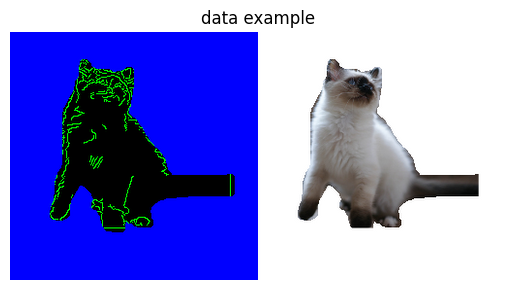

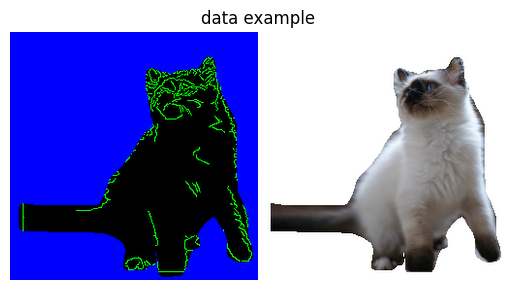

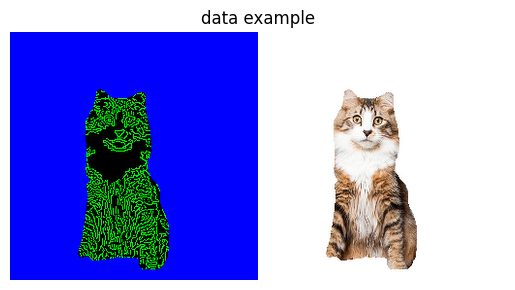

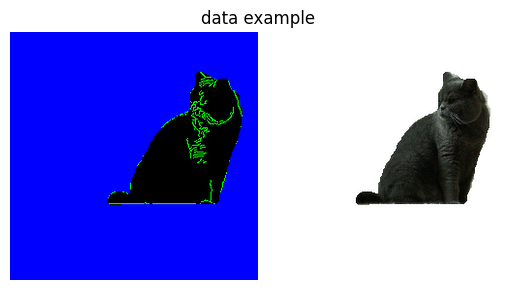

In [7]:
dataset = data_config.train_dataset
show_data_sample(dataset[0])
show_data_sample(dataset[0])
show_data_sample(dataset[1])
show_data_sample(dataset[3])

In [9]:
dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]], dtype=torch.float64),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1.

In [10]:
torch.unique(dataset[0][0])

tensor([-1.,  1.], dtype=torch.float64)

In [11]:
print(dataset[0][1].min(), dataset[0][1].max())

tensor(-0.9922) tensor(1.)


In [12]:
model = model_config.generator
model

UNet(
  (down_blocks): ModuleList(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr